# SYMFLUENCE Tutorial 1a — Point-Scale Workflow (Paradise SNOTEL)

## Introduction

This notebook demonstrates the point-scale modeling workflow in **SYMFLUENCE**, a framework for reproducible and modular computational hydrology. At the point scale, we simulate vertical energy and water fluxes at a single site, independent of routing or lateral flow, to isolate and evaluate model process representations.

Here, we focus on the **Paradise SNOTEL station (ID 602)**, located at 1,630 m elevation in Washington’s Cascade Range. This site represents a transitional snow climate and provides long-term observations of snow water equivalent (SWE) and soil moisture across multiple depths. By reproducing the observed seasonal snow and soil moisture dynamics, this tutorial demonstrates how SYMFLUENCE structures a controlled, transparent, and fully reproducible point-scale experiment.

Through this example, you will see how configuration-driven workflows manage experiment setup, geospatial definition, input data preprocessing, model instantiation, and performance evaluation—building a foundation for more complex distributed modeling studies later in the series.


# Step 1 — Configuration (pick or generate)

We begin by selecting (or programmatically generating) a single configuration file that fully specifies the experiment. This keeps the workflow reproducible and makes initialization a one-liner.


In [1]:
# Step 1 — Create a site-specific configuration for the Paradise SNOTEL example

from pathlib import Path
import yaml

# Find SYMFLUENCE root by searching upward for 0_config_files directory
def find_symfluence_root():
    current = Path.cwd().resolve()
    for i in range(30):
        if '.ipynb_checkpoints' in str(current):
            if current.parent == current:
                break
            current = current.parent
            continue
        if (current / '0_config_files').exists():
            if '.ipynb_checkpoints' not in str(current):
                print(f"Found SYMFLUENCE root: {current}")
                return current
            else:
                current = current.parent
                continue
        if current.parent == current:
            break
        current = current.parent
    raise FileNotFoundError(f"Could not find SYMFLUENCE root (0_config_files directory). Last path checked: {current}")

SYMFLUENCE_CODE_DIR = find_symfluence_root()

# Path to the default template configuration
config_template = SYMFLUENCE_CODE_DIR / '0_config_files' / 'config_template.yaml'

# Load the base configuration
with open(config_template, "r") as f:
    config = yaml.safe_load(f)

# === Modify key entries for the Paradise SNOTEL point-scale case ===

# Define code directory — ensures relative paths resolve correctly
config["SYMFLUENCE_CODE_DIR"] = str(SYMFLUENCE_CODE_DIR)

# Get SYMFLUENCE_DATA_DIR from template
SYMFLUENCE_DATA_DIR = Path(config.get('SYMFLUENCE_DATA_DIR', 
                                       str(SYMFLUENCE_CODE_DIR.parent / 'data' / 'SYMFLUENCE_data'))).resolve()
config["SYMFLUENCE_DATA_DIR"] = str(SYMFLUENCE_DATA_DIR)

print(f"Using SYMFLUENCE_DATA_DIR: {SYMFLUENCE_DATA_DIR}")

# Restrict the spatial domain to a single site using latitude/longitude bounds
config["DOMAIN_DEFINITION_METHOD"] = "point"
config["DOMAIN_DISCRETIZATION"] = "GRUs"
config["BOUNDING_BOX_COORDS"] = "46.781/-121.751/46.779/-121.749"
config["POUR_POINT_COORDS"] = "46.78/-121.75"

# Enable automatic download of SNOTEL data for this station
config["DOWNLOAD_SNOTEL"] = True

# Specify model and forcing dataset used in this example
config["HYDROLOGICAL_MODEL"] = "SUMMA"
config["FORCING_DATASET"] = "ERA5"

# Define the temporal extent of the experiment
config["EXPERIMENT_TIME_START"] = "2000-01-01 01:00"
config["EXPERIMENT_TIME_END"] = "2002-12-31 23:00"
config['CALIBRATION_PERIOD'] = "2000-10-01, 2001-09-30"
config['EVALUATION_PERIOD'] = "2001-10-01, 2002-09-30"
config['SPINUP_PERIOD'] = "2000-01-01, 2000-09-30"

# Assign a descriptive domain name and experiment ID
config["DOMAIN_NAME"] = "paradise"
config["EXPERIMENT_ID"] = "run_1"

# MAF paths and settings
config['DATATOOL_DATASET_ROOT'] = '/path/to/meteorological-data/'
config['GISTOOL_DATASET_ROOT'] = '/path/to/geospatial-data/'
config['TOOL_CACHE'] = '/path/to/cache/dir'
config['CLUSTER_JSON'] = '/path/to/cluster.json'
config['SNOW_DATA_SOURCE'] = 'SNOTEL'
config['SNOW_STATIONS'] = '679'
config['ISMN_NETWORK'] = 'SCAN'
config['ISMN_STATIONS'] = '679'

# Optimization settings
config['OPTIMIZATION_TARGET'] = 'swe'
config['PARAMS_TO_CALIBRATE'] = 'tempCritRain,tempRangeTimestep,frozenPrecipMultip,albedoMax,albedoMinWinter,albedoDecayRate,constSnowDen,mw_exp,k_snow,z0Snow'
config['ITERATIVE_OPTIMIZATION_ALGORITHM'] = 'DDS'
config['OPTIMIZATION_METRIC'] = 'RMSE'
config['CALIBRATION_TIMESTEP'] = 'daily'

# === Save the customized configuration ===
out_config = SYMFLUENCE_CODE_DIR / '0_config_files' / 'config_paradise.yaml'
with open(out_config, "w") as f:
    yaml.dump(config, f, default_flow_style=False, sort_keys=False)

print(f"✅ New configuration written to: {out_config}")

Found SYMFLUENCE root: /Users/darrieythorsson/compHydro/code/SYMFLUENCE
Using SYMFLUENCE_DATA_DIR: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data
✅ New configuration written to: /Users/darrieythorsson/compHydro/code/SYMFLUENCE/0_config_files/config_paradise.yaml


## Step 1b — Download Example Data (Optional)

If you don't have access to MAF-supported HPC resources, you can download pre-processed example data from GitHub releases. This step downloads and extracts the example data to your SYMFLUENCE_DATA_DIR.

In [2]:
# Step 1c — Initialize SYMFLUENCE
import sys
sys.path.append(str(SYMFLUENCE_CODE_DIR))
from symfluence import SYMFLUENCE

config_path = SYMFLUENCE_CODE_DIR / '0_config_files' / 'config_paradise.yaml'
symfluence = SYMFLUENCE(config_path)

print("✅ SYMFLUENCE initialized successfully.")
print(f"Configuration loaded from: {config_path}")

2025-12-31 15:12:46 ● SYMFLUENCE Logging Initialized
2025-12-31 15:12:46 ● Domain: paradise
2025-12-31 15:12:46 ● Experiment ID: run_1
2025-12-31 15:12:46 ● Log Level: INFO
2025-12-31 15:12:46 ● Log File: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/_workLog_paradise/symfluence_general_paradise_20251231_151246.log
2025-12-31 15:12:46 ● Configuration logged to: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/_workLog_paradise/config_paradise_20251231_151246.yaml
2025-12-31 15:12:46 ● SYMFLUENCE initialized with config: /Users/darrieythorsson/compHydro/code/SYMFLUENCE/0_config_files/config_paradise.yaml
2025-12-31 15:12:46 ● Creating point domain shapefile from bounding box coordinates
2025-12-31 15:12:46 ● Point domain shapefile created successfully: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/shapefiles/river_basins/paradise_riverBasins_point.shp
2025-12-31 15:12:46 ● Bounding box: lat_min=46.779, lat_max=46.781, 

## Step 1b — Initialize SYMFLUENCE

With the configuration prepared, we now initialize **SYMFLUENCE**.  
This step reads the configuration file, sets up the project directory, and registers all workflow managers (data, domain, model, and evaluation).  


In [3]:
# Step 1b — Initialize SYMFLUENCE
import os, sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from symfluence import SYMFLUENCE  # adjust if your import path differs

config_path = "../../0_config_files/config_paradise.yaml"
symfluence = SYMFLUENCE(config_path)

print("✅ SYMFLUENCE initialized successfully.")
print(f"Configuration loaded from: {config_path}")

2025-12-31 15:12:46 ● SYMFLUENCE Logging Initialized
2025-12-31 15:12:46 ● Domain: paradise
2025-12-31 15:12:46 ● Experiment ID: run_1
2025-12-31 15:12:46 ● Log Level: INFO
2025-12-31 15:12:46 ● Log File: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/_workLog_paradise/symfluence_general_paradise_20251231_151246.log
2025-12-31 15:12:46 ● Configuration logged to: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/_workLog_paradise/config_paradise_20251231_151246.yaml
2025-12-31 15:12:46 ● SYMFLUENCE initialized with config: ../../0_config_files/config_paradise.yaml
2025-12-31 15:12:46 ● Creating point domain shapefile from bounding box coordinates
2025-12-31 15:12:46 ● Point domain shapefile created successfully: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/shapefiles/river_basins/paradise_riverBasins_point.shp
2025-12-31 15:12:46 ● Bounding box: lat_min=46.779, lat_max=46.781, lon_min=-121.751, lon_max=-121.749
2025-12-

## Step 1c — Project structure setup

We now create the standardized project directory and a pour-point feature for the site.  
This anchors the experiment in a clear, reproducible file layout and records the site location for downstream domain and data steps.


In [4]:
# Step 1c — Project structure setup

from pathlib import Path

# 1) Create the standardized project layout (logs, config link, data/output folders, etc.)
project_dir = symfluence.managers['project'].setup_project()

# 2) Create a pour-point feature (the site reference geometry for point-scale workflows)
pour_point_path = symfluence.managers['project'].create_pour_point()

print("✅ Project structure created.")
print(f"Project root: {project_dir}")
print(f"Pour point:   {pour_point_path}")

# 3) Brief top-level directory preview
print("\nTop-level structure:")
for p in sorted(Path(project_dir).iterdir()):
    if p.is_dir():
        print(f"├── {p.name}")

2025-12-31 15:12:46 ● Setting up project for domain: paradise
2025-12-31 15:12:46 ● Project directory created at: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise
2025-12-31 15:12:47 ● Pour point shapefile created successfully: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/shapefiles/pour_point/paradise_pourPoint.shp
✅ Project structure created.
Project root: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise
Pour point:   /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/shapefiles/pour_point/paradise_pourPoint.shp

Top-level structure:
├── _workLog_paradise
├── attributes
├── forcing
├── observations
├── optimization
├── shapefiles


## Step 2 — Domain definition (point-scale GRU)

For the Paradise SNOTEL example, the domain is a **single GRU** representing the site footprint.  
This keeps the workflow strictly point-scale (no routing), aligning the geometry with the pour point created in Step 1.

### Step 2a — Geospatial attribute acquisition - **Only available through MAF supported HPCs**

We first acquire site attributes (elevation, land cover, soils, etc.).  
These are model-agnostic inputs used to parameterize vertical energy and water balance at the site.

- If you are using the downloaded example data. Copy the attributes, forcing and observation directories into the newly created domain directory from step 1c

In [5]:
# Step 2a — Acquire attributes (model-agnostic)
# If you are using MAF supported HPC, uncomment the below line
#symfluence.managers['data'].acquire_attributes()
print("✅ Attribute acquisition complete")

✅ Attribute acquisition complete


### Step 2b — Domain definition (point-scale)

With attributes prepared, we define a point-scale domain consistent with the pour point.  
For this example, the domain is a minimal footprint around the Paradise SNOTEL site.

In [6]:
# Step 2b — Define the point-scale domain
watershed_path = symfluence.managers['domain'].define_domain()
print("✅ Domain definition complete")
print(f"Domain file: {watershed_path}")

2025-12-31 15:12:47 ● Domain definition workflow starting with: point
2025-12-31 15:12:47 ● Creating point domain shapefile from bounding box coordinates
2025-12-31 15:12:47 ● Point domain shapefile created successfully: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/shapefiles/river_basins/paradise_riverBasins_point.shp
2025-12-31 15:12:47 ● Bounding box: lat_min=46.779, lat_max=46.781, lon_min=-121.751, lon_max=-121.749
2025-12-31 15:12:47 ● Area: 0.000004 square degrees
2025-12-31 15:12:47 ● Domain definition completed using method: point
2025-12-31 15:12:47 ● Domain map saved to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/plots/domain/domain_map.png
2025-12-31 15:12:47 ● Domain definition workflow finished
✅ Domain definition complete
Domain file: (PosixPath('/Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/shapefiles/river_basins/paradise_riverBasins_point.shp'), DelineationArtifacts(method='point', river_basins

### Step 2c — Discretization (required even for 1 GRU = 1 HRU)

Discretization writes the **catchment HRU shapefile** and related artifacts required by downstream steps.  
For the point-scale case we set `DOMAIN_DISCRETIZATION: GRUs`, which creates a **single HRU** identical to the GRU while still generating the standardized outputs.


In [7]:
# Step 2c — Discretization (GRUs → HRUs 1:1, but files are still created)
hru_path = symfluence.managers['domain'].discretize_domain()
print("✅ Domain discretization complete")
print(f"HRU file: {hru_path}")

2025-12-31 15:12:47 ● Discretizing domain using method: GRUs
2025-12-31 15:12:47 ● Starting domain discretization using attributes: ['GRUs']
Step 1/2: Running single attribute discretization method
2025-12-31 15:12:47 ● config domain name paradise
2025-12-31 15:12:47 ● Calculating mean elevation for each HRU
2025-12-31 15:12:47 ● DEM CRS: EPSG:4326
2025-12-31 15:12:47 ● Shapefile CRS: EPSG:4326
2025-12-31 15:12:47 ● CRS match - no reprojection needed
2025-12-31 15:12:47 ● Successfully calculated elevation statistics for 1 HRUs
2025-12-31 15:12:47 ● Calculated centroids in WGS84: lat range 46.780000 to 46.780000, lon range -121.750000 to -121.750000
2025-12-31 15:12:47 ● GRUs saved as HRUs to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/shapefiles/catchment/paradise_HRUs_GRUs.shp
2025-12-31 15:12:47 ● HRU plot saved to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/plots/catchment/paradise_HRUs_as_GRUs.png
Step 2/2: Sorting catchment shape

## Step 2d — Verification & inspection (Paradise SNOTEL)

We verify that discretization produced the expected shapefiles in the standardized locations, then plot a minimal GRU–HRU overlay.

**Expected files**
- `domain_dir/shapefiles/river_basins/paradise_riverBasins_point.shp` (GRU)
- `domain_dir/shapefiles/catchment/paradise_HRUs_GRUs.shp` (HRU)


✅ GRU file found: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/shapefiles/river_basins/paradise_riverBasins_point.shp
✅ HRU file found: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/shapefiles/catchment/paradise_HRUs_GRUs.shp


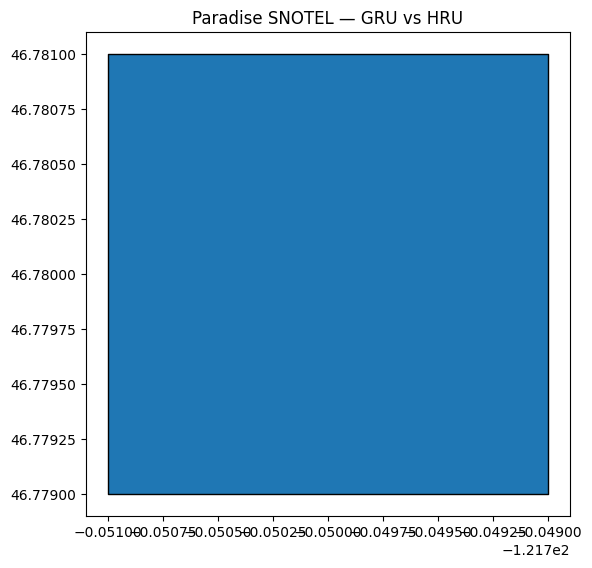

In [8]:
# Step 2d — Verify domain outputs and inspect geometry

from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import yaml

# 1) Read config to get data dir and domain name
with open("../../0_config_files/config_paradise.yaml") as f:
    cfg = yaml.safe_load(f)

data_dir   = Path(cfg["SYMFLUENCE_DATA_DIR"])
domain_dir = data_dir / f"domain_{cfg['DOMAIN_NAME']}"
shp_dir    = domain_dir / "shapefiles"

# 2) Explicit expected shapefiles for Paradise
gru_fp = shp_dir / "river_basins" / "paradise_riverBasins_point.shp"
hru_fp = shp_dir / "catchment"     / "paradise_HRUs_GRUs.shp"

# 3) Verify presence
for label, path in [("GRU", gru_fp), ("HRU", hru_fp)]:
    if not path.exists():
        raise FileNotFoundError(f"❌ Expected {label} file not found: {path}")
    print(f"✅ {label} file found: {path}")

# 4) Minimal overlay plot
gru = gpd.read_file(gru_fp)
hru = gpd.read_file(hru_fp)
if hru.crs != gru.crs:
    hru = hru.to_crs(gru.crs)

ax = gru.plot(figsize=(6, 6))
hru.plot(ax=ax, facecolor="none")
ax.set_title("Paradise SNOTEL — GRU vs HRU")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

# Step 3 — Input preprocessing (model-agnostic)

We prepare inputs in three small moves:
1) acquire **meteorological forcings**,  
2) process **observations** (SNOTEL), and  
3) run **model-agnostic preprocessing** to standardize time steps, variables, and units for downstream use.

### Step 3a — Acquire meteorological forcings (ERA5)

Downloads/subsets the forcings for the Paradise domain.


In [9]:
# Step 3a — Forcings
# If you are using MAF supported HPC, uncomment the below line
# symfluence.managers['data'].acquire_forcings()
print("✅ Forcing data acquisition complete")


✅ Forcing data acquisition complete


### Step 3b — Process observations (SNOTEL)

Parses site observations (e.g., SWE, soil moisture), applies basic QA/QC, and stores standardized outputs.


In [10]:
# Step 3b — Observations
# If you are using MAF supported HPC, uncomment the below line
#symfluence.managers['data'].process_observed_data()
print("✅ Observational data processing complete")

✅ Observational data processing complete


### Step 3c — Model-agnostic preprocessing

Standardizes variable names, units, and time steps (and fills required diagnostics) so multiple models can consume the same inputs consistently.

In [11]:
# Step 3c — Model-agnostic preprocessing
symfluence.managers['data'].run_model_agnostic_preprocessing()
print("✅ Model-agnostic preprocessing complete")

2025-12-31 15:12:47 ● Starting model-agnostic preprocessing
2025-12-31 15:12:47 ● Running geospatial statistics
2025-12-31 15:12:47 ● Starting geospatial statistics calculation
2025-12-31 15:12:47 ● Calculating soil statistics
2025-12-31 15:12:47 ● Soil raster CRS: EPSG:4326
2025-12-31 15:12:47 ● Catchment shapefile CRS: EPSG:4326
2025-12-31 15:12:47 ● CRS match - no reprojection needed
2025-12-31 15:12:47 ● Soil statistics saved to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/shapefiles/catchment_intersection/with_soilgrids/catchment_with_soilclass.shp
2025-12-31 15:12:47 ● Calculating land statistics
2025-12-31 15:12:47 ● Land raster CRS: EPSG:4326
2025-12-31 15:12:47 ● Catchment shapefile CRS: EPSG:4326
2025-12-31 15:12:47 ● CRS match - no reprojection needed
2025-12-31 15:12:47 ● Land statistics saved to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/shapefiles/catchment_intersection/with_landclass/catchment_with_landclass.shp
2025-12

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/pyogrio/raw.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200001.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200001.nc 
Started at date and time 2025-12-31 15:12:47.838540 
Ended at date and time 2025-12-31 15:12:51.936109 
It took 4.097569 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:51 ● ✓ Successfully processed domain_paradise_ERA5_merged_200001.nc (1/36)
2025-12-31 15:12:51 ● Processing file 2/36: domain_paradise_ERA5_merged_200002.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  air

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200002.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200002.nc 
Started at date and time 2025-12-31 15:12:51.959550 
Ended at date and time 2025-12-31 15:12:55.788469 
It took 3.828919 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:55 ● ✓ Successfully processed domain_paradise_ERA5_merged_200002.nc (2/36)
2025-12-31 15:12:55 ● Processing file 3/36: domain_paradise_ERA5_merged_200003.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  air

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200003.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200003.nc 
Started at date and time 2025-12-31 15:12:55.811972 
Ended at date and time 2025-12-31 15:12:59.900412 
It took 4.08844 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:59 ● ✓ Successfully processed domain_paradise_ERA5_merged_200003.nc (3/36)
2025-12-31 15:12:59 ● Processing file 4/36: domain_paradise_ERA5_merged_200004.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  airp

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200004.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200004.nc 
Started at date and time 2025-12-31 15:12:59.923535 
Ended at date and time 2025-12-31 15:13:03.908875 
It took 3.98534 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:03 ● ✓ Successfully processed domain_paradise_ERA5_merged_200004.nc (4/36)
2025-12-31 15:13:03 ● Processing file 5/36: domain_paradise_ERA5_merged_200005.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  airp

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200005.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200005.nc 
Started at date and time 2025-12-31 15:13:03.933989 
Ended at date and time 2025-12-31 15:13:08.007783 
It took 4.073794 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:08 ● ✓ Successfully processed domain_paradise_ERA5_merged_200005.nc (5/36)
2025-12-31 15:13:08 ● Processing file 6/36: domain_paradise_ERA5_merged_200006.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  air

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200006.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200006.nc 
Started at date and time 2025-12-31 15:13:08.031375 
Ended at date and time 2025-12-31 15:13:12.012108 
It took 3.980733 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:12 ● ✓ Successfully processed domain_paradise_ERA5_merged_200006.nc (6/36)
2025-12-31 15:13:12 ● Processing file 7/36: domain_paradise_ERA5_merged_200007.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  air

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200007.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200007.nc 
Started at date and time 2025-12-31 15:13:12.037779 
Ended at date and time 2025-12-31 15:13:16.144194 
It took 4.106415 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:16 ● ✓ Successfully processed domain_paradise_ERA5_merged_200007.nc (7/36)
2025-12-31 15:13:16 ● Processing file 8/36: domain_paradise_ERA5_merged_200008.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  air

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200008.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200008.nc 
Started at date and time 2025-12-31 15:13:16.168015 
Ended at date and time 2025-12-31 15:13:20.419845 
It took 4.25183 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:20 ● ✓ Successfully processed domain_paradise_ERA5_merged_200008.nc (8/36)
2025-12-31 15:13:20 ● Processing file 9/36: domain_paradise_ERA5_merged_200009.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  airp

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200009.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200009.nc 
Started at date and time 2025-12-31 15:13:20.445038 
Ended at date and time 2025-12-31 15:13:24.685112 
It took 4.240074 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:24 ● ✓ Successfully processed domain_paradise_ERA5_merged_200009.nc (9/36)
2025-12-31 15:13:24 ● Processing file 10/36: domain_paradise_ERA5_merged_200010.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  ai

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200010.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200010.nc 
Started at date and time 2025-12-31 15:13:24.709131 
Ended at date and time 2025-12-31 15:13:29.240746 
It took 4.531615 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:29 ● ✓ Successfully processed domain_paradise_ERA5_merged_200010.nc (10/36)
2025-12-31 15:13:29 ● Progress: 10/36 files processed (10 successful)
2025-12-31 15:13:29 ● Processing file 11/36: domain_paradise_ERA5_merged_200011.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this fi

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200011.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200011.nc 
Started at date and time 2025-12-31 15:13:29.265951 
Ended at date and time 2025-12-31 15:13:33.408273 
It took 4.142322 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:33 ● ✓ Successfully processed domain_paradise_ERA5_merged_200011.nc (11/36)
2025-12-31 15:13:33 ● Processing file 12/36: domain_paradise_ERA5_merged_200012.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200012.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200012.nc 
Started at date and time 2025-12-31 15:13:33.437759 
Ended at date and time 2025-12-31 15:13:37.693517 
It took 4.255758 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:37 ● ✓ Successfully processed domain_paradise_ERA5_merged_200012.nc (12/36)
2025-12-31 15:13:37 ● Processing file 13/36: domain_paradise_ERA5_merged_200101.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200101.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200101.nc 
Started at date and time 2025-12-31 15:13:37.715825 
Ended at date and time 2025-12-31 15:13:41.939544 
It took 4.223719 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:41 ● ✓ Successfully processed domain_paradise_ERA5_merged_200101.nc (13/36)
2025-12-31 15:13:41 ● Processing file 14/36: domain_paradise_ERA5_merged_200102.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200102.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200102.nc 
Started at date and time 2025-12-31 15:13:41.961821 
Ended at date and time 2025-12-31 15:13:45.720770 
It took 3.758949 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:45 ● ✓ Successfully processed domain_paradise_ERA5_merged_200102.nc (14/36)
2025-12-31 15:13:45 ● Processing file 15/36: domain_paradise_ERA5_merged_200103.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200103.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200103.nc 
Started at date and time 2025-12-31 15:13:45.747119 
Ended at date and time 2025-12-31 15:13:49.904331 
It took 4.157212 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:49 ● ✓ Successfully processed domain_paradise_ERA5_merged_200103.nc (15/36)
2025-12-31 15:13:49 ● Processing file 16/36: domain_paradise_ERA5_merged_200104.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200104.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200104.nc 
Started at date and time 2025-12-31 15:13:49.930583 
Ended at date and time 2025-12-31 15:13:53.829482 
It took 3.898899 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:53 ● ✓ Successfully processed domain_paradise_ERA5_merged_200104.nc (16/36)
2025-12-31 15:13:53 ● Processing file 17/36: domain_paradise_ERA5_merged_200105.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200105.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200105.nc 
Started at date and time 2025-12-31 15:13:53.853805 
Ended at date and time 2025-12-31 15:13:58.024270 
It took 4.170465 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:58 ● ✓ Successfully processed domain_paradise_ERA5_merged_200105.nc (17/36)
2025-12-31 15:13:58 ● Processing file 18/36: domain_paradise_ERA5_merged_200106.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200106.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200106.nc 
Started at date and time 2025-12-31 15:13:58.049582 
Ended at date and time 2025-12-31 15:14:02.025409 
It took 3.975827 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:02 ● ✓ Successfully processed domain_paradise_ERA5_merged_200106.nc (18/36)
2025-12-31 15:14:02 ● Processing file 19/36: domain_paradise_ERA5_merged_200107.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200107.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200107.nc 
Started at date and time 2025-12-31 15:14:02.048991 
Ended at date and time 2025-12-31 15:14:06.176561 
It took 4.12757 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:06 ● ✓ Successfully processed domain_paradise_ERA5_merged_200107.nc (19/36)
2025-12-31 15:14:06 ● Processing file 20/36: domain_paradise_ERA5_merged_200108.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  ai

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200108.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200108.nc 
Started at date and time 2025-12-31 15:14:06.204252 
Ended at date and time 2025-12-31 15:14:10.316607 
It took 4.112355 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:10 ● ✓ Successfully processed domain_paradise_ERA5_merged_200108.nc (20/36)
2025-12-31 15:14:10 ● Progress: 20/36 files processed (20 successful)
2025-12-31 15:14:10 ● Processing file 21/36: domain_paradise_ERA5_merged_200109.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this fi

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200109.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200109.nc 
Started at date and time 2025-12-31 15:14:10.342073 
Ended at date and time 2025-12-31 15:14:14.355096 
It took 4.013023 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:14 ● ✓ Successfully processed domain_paradise_ERA5_merged_200109.nc (21/36)
2025-12-31 15:14:14 ● Processing file 22/36: domain_paradise_ERA5_merged_200110.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200110.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200110.nc 
Started at date and time 2025-12-31 15:14:14.378520 
Ended at date and time 2025-12-31 15:14:18.587633 
It took 4.209113 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:18 ● ✓ Successfully processed domain_paradise_ERA5_merged_200110.nc (22/36)
2025-12-31 15:14:18 ● Processing file 23/36: domain_paradise_ERA5_merged_200111.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200111.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200111.nc 
Started at date and time 2025-12-31 15:14:18.614010 
Ended at date and time 2025-12-31 15:14:22.656323 
It took 4.042313 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:22 ● ✓ Successfully processed domain_paradise_ERA5_merged_200111.nc (23/36)
2025-12-31 15:14:22 ● Processing file 24/36: domain_paradise_ERA5_merged_200112.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200112.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200112.nc 
Started at date and time 2025-12-31 15:14:22.682639 
Ended at date and time 2025-12-31 15:14:26.938875 
It took 4.256236 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:26 ● ✓ Successfully processed domain_paradise_ERA5_merged_200112.nc (24/36)
2025-12-31 15:14:26 ● Processing file 25/36: domain_paradise_ERA5_merged_200201.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200201.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200201.nc 
Started at date and time 2025-12-31 15:14:26.976742 
Ended at date and time 2025-12-31 15:14:31.381711 
It took 4.404969 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:31 ● ✓ Successfully processed domain_paradise_ERA5_merged_200201.nc (25/36)
2025-12-31 15:14:31 ● Processing file 26/36: domain_paradise_ERA5_merged_200202.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200202.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200202.nc 
Started at date and time 2025-12-31 15:14:31.418425 
Ended at date and time 2025-12-31 15:14:35.239160 
It took 3.820735 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:35 ● ✓ Successfully processed domain_paradise_ERA5_merged_200202.nc (26/36)
2025-12-31 15:14:35 ● Processing file 27/36: domain_paradise_ERA5_merged_200203.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200203.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200203.nc 
Started at date and time 2025-12-31 15:14:35.266115 
Ended at date and time 2025-12-31 15:14:39.675927 
It took 4.409812 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:39 ● ✓ Successfully processed domain_paradise_ERA5_merged_200203.nc (27/36)
2025-12-31 15:14:39 ● Processing file 28/36: domain_paradise_ERA5_merged_200204.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200204.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200204.nc 
Started at date and time 2025-12-31 15:14:39.707545 
Ended at date and time 2025-12-31 15:14:43.651591 
It took 3.944046 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:43 ● ✓ Successfully processed domain_paradise_ERA5_merged_200204.nc (28/36)
2025-12-31 15:14:43 ● Processing file 29/36: domain_paradise_ERA5_merged_200205.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200205.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200205.nc 
Started at date and time 2025-12-31 15:14:43.680507 
Ended at date and time 2025-12-31 15:14:47.808226 
It took 4.127719 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:47 ● ✓ Successfully processed domain_paradise_ERA5_merged_200205.nc (29/36)
2025-12-31 15:14:47 ● Processing file 30/36: domain_paradise_ERA5_merged_200206.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200206.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200206.nc 
Started at date and time 2025-12-31 15:14:47.830813 
Ended at date and time 2025-12-31 15:14:51.843884 
It took 4.013071 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:51 ● ✓ Successfully processed domain_paradise_ERA5_merged_200206.nc (30/36)
2025-12-31 15:14:51 ● Progress: 30/36 files processed (30 successful)
2025-12-31 15:14:51 ● Processing file 31/36: domain_paradise_ERA5_merged_200207.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this fi

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200207.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200207.nc 
Started at date and time 2025-12-31 15:14:51.869343 
Ended at date and time 2025-12-31 15:14:56.002248 
It took 4.132905 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:56 ● ✓ Successfully processed domain_paradise_ERA5_merged_200207.nc (31/36)
2025-12-31 15:14:56 ● Processing file 32/36: domain_paradise_ERA5_merged_200208.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200208.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200208.nc 
Started at date and time 2025-12-31 15:14:56.025444 
Ended at date and time 2025-12-31 15:15:00.383008 
It took 4.357564 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:00 ● ✓ Successfully processed domain_paradise_ERA5_merged_200208.nc (32/36)
2025-12-31 15:15:00 ● Processing file 33/36: domain_paradise_ERA5_merged_200209.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200209.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200209.nc 
Started at date and time 2025-12-31 15:15:00.425448 
Ended at date and time 2025-12-31 15:15:04.754071 
It took 4.328623 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:04 ● ✓ Successfully processed domain_paradise_ERA5_merged_200209.nc (33/36)
2025-12-31 15:15:04 ● Processing file 34/36: domain_paradise_ERA5_merged_200210.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200210.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200210.nc 
Started at date and time 2025-12-31 15:15:04.789078 
Ended at date and time 2025-12-31 15:15:09.763918 
It took 4.97484 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:09 ● ✓ Successfully processed domain_paradise_ERA5_merged_200210.nc (34/36)
2025-12-31 15:15:09 ● Processing file 35/36: domain_paradise_ERA5_merged_200211.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  ai

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200211.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200211.nc 
Started at date and time 2025-12-31 15:15:09.811815 
Ended at date and time 2025-12-31 15:15:14.144412 
It took 4.332597 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:14 ● ✓ Successfully processed domain_paradise_ERA5_merged_200211.nc (35/36)
2025-12-31 15:15:14 ● Processing file 36/36: domain_paradise_ERA5_merged_200212.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
remap file is provided; EASYMORE will use this file and skip creation of remapping file
EASYMORE will remap variable  a

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200212.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200212.nc 
Started at date and time 2025-12-31 15:15:14.174213 
Ended at date and time 2025-12-31 15:15:18.754885 
It took 4.580672 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:18 ● ✓ Successfully processed domain_paradise_ERA5_merged_200212.nc (36/36)
2025-12-31 15:15:18 ● Processing complete: 36 files processed successfully out of 36
2025-12-31 15:15:18 ● Total files processed or skipped: 36 out of 36
2025-12-31 15:15:18 ● Forcing remapping process completed
2025-12-31 15:15:18 ● Forcing data resampling process completed
2025-12-31 15:15:18 ● Model-agnostic preprocessing completed successfully
✅ Model-agnostic preprocessing complete


### Step 3d — Quick verification

We confirm the expected folders exist and contain files:

- `forcing/raw_data/`
- `forcing/basin_averaged_data/`
- `observations/snow/{raw,processed}/`
- `observations/soil_moisture/{raw,processed}/`


In [12]:
from pathlib import Path
import yaml

# Derive paths from the config (no hard-coding)
with open("../../0_config_files/config_paradise.yaml") as f:
    cfg = yaml.safe_load(f)

data_dir   = Path(cfg["SYMFLUENCE_DATA_DIR"])
domain_dir = data_dir / f"domain_{cfg['DOMAIN_NAME']}"

targets = {
    "forcing/raw_data":                  domain_dir / "forcing" / "raw_data",
    "forcing/basin_averaged_data":       domain_dir / "forcing" / "basin_averaged_data",
    "observations/snow/raw":             domain_dir / "observations" / "snow" / "swe" / "raw",
    "observations/snow/processed":       domain_dir / "observations" / "snow" / "swe" / "processed",
    "observations/soil_moisture/raw":    domain_dir / "observations" / "soil_moisture" / "ismn" / "raw",
    "observations/soil_moisture/processed": domain_dir / "observations" / "soil_moisture" / "ismn" / "processed",
}

def count_files(p: Path) -> int:
    return sum(1 for x in p.iterdir() if x.is_file()) if p.exists() else 0

for label, path in targets.items():
    exists = path.exists()
    n = count_files(path)
    status = "✅" if exists and n > 0 else ("⚠️ empty" if exists else "❌ missing")
    suffix = f"({n} files)" if exists else ""
    print(f"{status} {label}  {suffix}")

✅ forcing/raw_data  (36 files)
✅ forcing/basin_averaged_data  (36 files)
✅ observations/snow/raw  (1 files)
✅ observations/snow/processed  (1 files)
✅ observations/soil_moisture/raw  (2 files)
✅ observations/soil_moisture/processed  (1 files)


# Step 4 — Model-specific preprocessing & model run (SUMMA)

We now convert the model-agnostic inputs into **SUMMA-ready inputs**, then instantiate and run the model for the Paradise point-scale case.


### Step 4a — SUMMA-specific preprocessing

Creates the SUMMA input bundle (metadata, parameter tables, forcing links) from the standardized inputs.


In [13]:
# Step 4a — SUMMA-specific preprocessing
symfluence.managers['model'].preprocess_models()
print("✅ Model-specific preprocessing complete")

2025-12-31 15:15:18 ● Starting model-specific preprocessing
2025-12-31 15:15:18 ● Starting SUMMA spatial preprocessing
2025-12-31 15:15:18 ● Starting memory-efficient temperature lapse rate and data step application
2025-12-31 15:15:18 ● Converting /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/shapefiles/catchment_intersection/with_forcing/paradise_ERA5_intersected_shapefile.shp to CSV format
2025-12-31 15:15:18 ● Successfully created /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/shapefiles/catchment_intersection/with_forcing/paradise_ERA5_intersected_shapefile.csv
2025-12-31 15:15:19 ● Loading topology data...
2025-12-31 15:15:19 ● Loaded topology data: 1 rows, 0.00 MB
2025-12-31 15:15:19 ● Found 36 forcing files to process
2025-12-31 15:15:19 ● Pre-calculating lapse rate corrections...
2025-12-31 15:15:19 ● Prepared lapse corrections for 1 HRUs
2025-12-31 15:15:19 ● Processing files in batches of 36
2025-12-31 15:15:21 ● Completed proce

## Step 4b — Instantiate & run the model

Instantiates the model using the prepared inputs and executes the point-scale simulation.


In [14]:
# Step 4b — Instantiate & run SUMMA
print(f"Running {symfluence.config['HYDROLOGICAL_MODEL']} for point-scale simulation…")
symfluence.managers['model'].run_models()
print("✅ Point-scale model run complete")

Running SUMMA for point-scale simulation…
2025-12-31 15:15:21 ● Starting model runs
2025-12-31 15:15:21 ● Running model: SUMMA
2025-12-31 15:15:21 ● Starting SUMMA run
2025-12-31 15:15:21 ● Running SUMMA with LD_LIBRARY_PATH: 
2025-12-31 15:15:21 ● SUMMA binary: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/installs/summa/bin/summa_sundials.exe
2025-12-31 15:15:21 ● File manager: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/settings/SUMMA/fileManager.txt
2025-12-31 15:15:31 ● SUMMA run completed successfully
✅ Point-scale model run complete


### Step 4c - Quick verification

Print where SUMMA inputs and run outputs were written (paths are derived from the configuration).


In [15]:
from pathlib import Path
import yaml

with open("../../0_config_files/config_paradise.yaml") as f:
    cfg = yaml.safe_load(f)

data_dir   = Path(cfg["SYMFLUENCE_DATA_DIR"])
domain_dir = data_dir / f"domain_{cfg['DOMAIN_NAME']}"

# Common locations used by the model manager
summa_in   = domain_dir / "forcing" / "SUMMA_input"
results    = domain_dir / "simulations" / cfg['EXPERIMENT_ID'] / 'SUMMA' 

print("SUMMA input dir:", summa_in if summa_in.exists() else "(not found)")
print("Results dir:",    results if results.exists()    else "(not found)")

SUMMA input dir: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/forcing/SUMMA_input
Results dir: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/simulations/run_1/SUMMA


Opened: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/simulations/run_1/SUMMA/run_1_day.nc
SWE sim range: 2001-01-01 00:00:00 → 2002-12-31 00:00:00
SWE obs range: 1980-10-01 00:00:00 → 2024-03-25 00:00:00
SWE overlap days: 730
Detected obs SWE units: cm (×10.0)
SWE metrics: {'RMSE': 91.441, 'Bias': 33.973, 'r': 0.981}


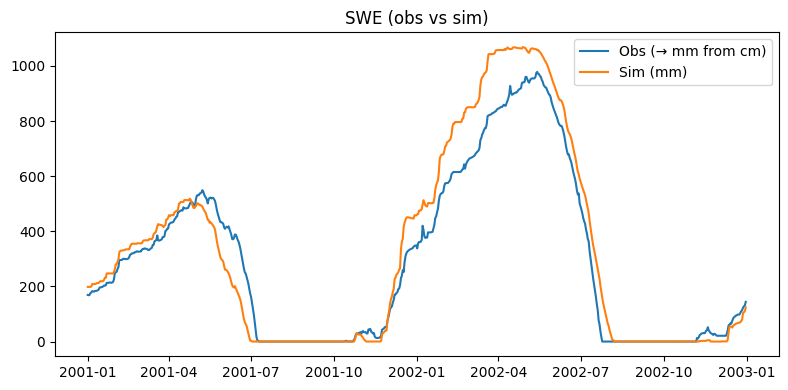

In [16]:
# Step 4c — SWE only (obs vs sim) with robust NetCDF open + unit auto-detect

from pathlib import Path
import yaml, pandas as pd, numpy as np, xarray as xr
import matplotlib.pyplot as plt
import re

# --- Paths from config ---
with open("../../0_config_files/config_paradise.yaml") as f:
    cfg = yaml.safe_load(f)
data_dir   = Path(cfg["SYMFLUENCE_DATA_DIR"])
domain_dir = data_dir / f"domain_{cfg['DOMAIN_NAME']}"

# Find a daily SUMMA output (e.g., *_day.nc) under the domain folder
nc_files = list(domain_dir.rglob("*_day.nc"))
if not nc_files:
    # fallback: any .nc under results
    nc_files = list((domain_dir / "simulations" / cfg['EXPERIMENT_ID'] / "SUMMA").rglob("_day.nc"))
if not nc_files:
    raise FileNotFoundError(f"No netCDF files found under {domain_dir}")
nc_path = nc_files[0]

def open_dataset_safe(path: Path) -> xr.Dataset:
    if not path.exists():
        raise FileNotFoundError(f"Path does not exist: {path}")
    if path.is_dir() or path.suffix.lower() == ".zarr":
        # Zarr store
        return xr.open_zarr(path)
    errs = []
    for eng in ("netcdf4", "scipy"):
        try:
            return xr.open_dataset(path, engine=eng)
        except Exception as e:
            errs.append(f"{eng}: {e}")
    raise ValueError(f"Could not open {path} with engines netcdf4/scipy.\n" + "\n".join(errs))

# --- Helpers ---
def rmse(a, b): 
    d = (a - b).to_numpy(dtype=float)
    return float(np.sqrt(np.nanmean(d**2)))

def bias(a, b):
    return float((a - b).mean())

def first_numeric_col(df):
    cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    return cols[0] if cols else None

def reduce_to_time_series(da: xr.DataArray) -> pd.Series:
    if "time" not in da.dims:
        if "time" in da.coords:
            da = da.swap_dims({list(da.dims)[0]: "time"})
        else:
            raise ValueError("DataArray has no 'time' dimension or coordinate.")
    # pick first layer if present; average any spatial dims (hru/gru)
    for d in [d for d in da.dims if d != "time"]:
        if re.search("layer|soil", d, re.I):
            da = da.isel({d: 0})
        else:
            da = da.mean(d)
    s = da.to_series()
    s.index = pd.to_datetime(s.index)
    return s.sort_index()

def read_obs_csv(path: Path):
    df = pd.read_csv(path, index_col=0)
    if not isinstance(df.index, pd.DatetimeIndex):
        df = pd.read_csv(path)
        date_col = next(c for c in df.columns if re.search("date|time", str(c), re.I))
        df[date_col] = pd.to_datetime(df[date_col].astype(str).str.strip(), dayfirst=True, errors="raise")
        df = df.set_index(date_col)
    df = df.sort_index()
    col = first_numeric_col(df)
    if not col:
        raise ValueError(f"No numeric SWE column found in {path}")
    return df[col].astype(float), str(col)

def align(a, b):
    idx = a.index.intersection(b.index)
    return a.loc[idx].astype(float), b.loc[idx].astype(float)

# --- Open dataset robustly & handle spinup safely ---
ds = open_dataset_safe(nc_path)

# robust time extraction
time_vals = ds.get("time")
if time_vals is None or np.size(time_vals) == 0:
    raise ValueError("Dataset has no usable 'time' coordinate.")
time_pd = pd.to_datetime(np.array(time_vals.values), errors="coerce")
if pd.isna(time_pd).all():
    # cftime fallback
    time_pd = pd.to_datetime([f"{t.year:04d}-{t.month:02d}-{t.day:02d}" for t in time_vals.values])
start_year = int(time_pd.min().year) + 1

ds_eval = ds.sel(time=slice(f"{start_year}-01-01", None))
if ds_eval.sizes.get("time", 0) == 0:
    ds_eval = ds  # if skipping a year empties it, use full record

# SWE (simulation) — expected in mm
swe_var_candidates = ["scalarSWE", "scalarSnowWaterEquivalent", "SWE"]
swe_var = next((v for v in swe_var_candidates if v in ds_eval.data_vars), None)
if not swe_var:
    raise KeyError(f"SWE variable not found. Tried: {swe_var_candidates}")
swe_sim = reduce_to_time_series(ds_eval[swe_var])

# --- Load SWE observations (processed; unknown units) ---
swe_obs_csv1 = domain_dir / "observations" / "snow" / "processed" / f"{cfg['DOMAIN_NAME']}_swe_processed.csv"
swe_obs_csv2 = domain_dir / "observations" / "snow" / "swe" / "processed" / f"{cfg['DOMAIN_NAME']}_swe_processed.csv"
swe_obs_csv  = swe_obs_csv1 if swe_obs_csv1.exists() else swe_obs_csv2
swe_obs_raw, swe_obs_col = read_obs_csv(swe_obs_csv)

# --- Unit auto-detection: assume sim is mm; try mm/cm/in for obs ---
candidates = {"mm": 1.0, "cm": 10.0, "in": 25.4}
scores, aligned_examples = {}, {}
for unit, factor in candidates.items():
    obs_scaled = swe_obs_raw * factor
    sim_a, obs_a = align(swe_sim, obs_scaled)
    if len(sim_a) == 0:
        scores[unit] = np.inf
    else:
        scores[unit] = rmse(sim_a, obs_a)
        aligned_examples[unit] = (sim_a, obs_a)

best_unit = min(scores, key=scores.get)
scale = candidates[best_unit]
if not np.isfinite(scores[best_unit]):
    raise ValueError("No overlapping dates between SWE sim and obs.")
swe_sim_a, swe_obs_a = aligned_examples[best_unit]

# --- Metrics & diagnostics ---
def corr(a, b): return float(pd.Series(a).corr(pd.Series(b)))

swe_metrics = dict(RMSE=rmse(swe_sim_a, swe_obs_a),
                   Bias=bias(swe_sim_a, swe_obs_a),
                   r=corr(swe_sim_a, swe_obs_a))

print(f"Opened: {nc_path}")
print(f"SWE sim range: {swe_sim.index.min()} → {swe_sim.index.max()}")
print(f"SWE obs range: {swe_obs_raw.index.min()} → {swe_obs_raw.index.max()}")
print(f"SWE overlap days: {len(swe_sim_a)}")
print(f"Detected obs SWE units: {best_unit} (×{scale})")
print("SWE metrics:", {k: round(v,3) for k,v in swe_metrics.items()})

# --- Plot ---
plt.figure(figsize=(8,4))
plt.plot(swe_obs_a.index, swe_obs_a.values, label=f"Obs (→ mm from {best_unit})")
plt.plot(swe_sim_a.index, swe_sim_a.values, label="Sim (mm)")
plt.title("SWE (obs vs sim)")
plt.legend()
plt.tight_layout()
plt.show()

ds.close()


# Step 5 — Calibration (SUMMA, Differential Evolution)

We enable **iterative calibration** for SUMMA, set the **calibration/evaluation periods**, choose **parameters**, and pick a **single objective** (KGE).  
SYMFLUENCE exposes a one-liner to run calibration once config is set.


## Step 5a — Minimal config (what matters)

Add/confirm these in `config_paradise.yaml`:

```yaml
# Enable iterative calibration with DE, use KGE on the calibration window
OPTIMIZATION_METHODS: [iteration]
ITERATIVE_OPTIMIZATION_ALGORITHM: DE      # DE, DDS, PSO, SCE-UA, NSGA-II
OPTIMIZATION_METRIC: KGE                  # KGE, NSE, RMSE, MAE, KGEp

# Parameters to calibrate (point-scale set)
PARAMS_TO_CALIBRATE: tempCritRain,k_soil,vGn_n,theta_sat


In [17]:
# Step 5b — Run calibration (DE + KGE)

results_file = symfluence.managers['optimization'].calibrate_model()  
print("Calibration results file:", results_file)

2025-12-31 15:15:31 ● Starting model calibration
2025-12-31 15:15:31 ● Using DDS optimization
2025-12-31 15:15:31 ● Local scratch mode DISABLED for rank 0 - using standard filesystem
2025-12-31 15:15:31 ● optimization_dir set to: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_paradise/simulations/run_dds
2025-12-31 15:15:31 ● Using spinup + calibration period: 2000-01-01 01:00 to 2001-09-30 23:00
2025-12-31 15:15:31 ● Calibration will use daily timestep
2025-12-31 15:15:31 ● Initialized SnowTarget for SWE calibration
2025-12-31 15:15:36 ● Resampling data to daily timestep
2025-12-31 15:15:43 ● Resampling data to daily timestep
2025-12-31 15:15:50 ● Resampling data to daily timestep
2025-12-31 15:15:56 ● Resampling data to daily timestep
2025-12-31 15:16:03 ● Resampling data to daily timestep
2025-12-31 15:16:09 ● Resampling data to daily timestep
2025-12-31 15:16:16 ● Resampling data to daily timestep
2025-12-31 15:16:22 ● Resampling data to daily timestep
2025-12-31 15:1